In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.patches import Patch
import numpy as np
import math
from pathlib import Path
# Set up matplotlib
%matplotlib inline
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
# Per-platform data
platforms = ['pi4', 'pi3']
platform_names = ['Raspberry Pi 4 B','Raspberry Pi 3 B']
short_platform_names = ['Pi 4', 'Pi 3']
image_folder_names = platforms
data_folder_names = ['results4', 'results5']
platform_indices = range(0, len(platforms))

# Base measurements - on which deltas are based
base_measurements = ['duration', 'spike_power', 'adjusted_power', 'peak_power', 'spike_watts', 'spike_median']

target = 'ieee'
# target = 'thesis'

In [3]:
def get_image_folder(i_platform):
    folder = Path(f'../images/{image_folder_names[i_platform]}')
    return folder

def get_data_folder(i_platform):
    folder = Path(f'../python/{data_folder_names[i_platform]}')
    return folder

In [4]:
# Prepare data for a platform
# i)   Create output folder as necessary
# ii)  Load input data spikes.csv
# iii) Clean up column names & add simple calculated columns
# iv)  Split spikes by model and merge models into a single set of rows
# v)   Join with experiments.csv
# vi)  Calculate deltas
def prepare_data(i_platform):
    # Prepare ionput & output folders
    data_folder = Path(get_data_folder(i_platform))
    image_folder = Path(get_image_folder(i_platform))
    image_folder.mkdir(parents=True, exist_ok=True)
    # Load spikes and filter outliers (i.e. pairincluded == False)
    spikes = pd.read_csv(data_folder / 'spikes.csv')
    spikes = spikes.rename(columns={'uuid':'experimentid'})
    spikes['spike_watts'] = spikes['spike_power']/spikes['duration']
    spikesf = spikes[spikes['pairincluded']==True]
    # Add more calculated series
    # Split the execution models
    ss = spikesf[spikesf['model']=='seq']
    sc = spikesf[spikesf['model']=='coro']
    # Consistency check
    assert len(ss)==len(sc),'spike counts do not match'
    for i in range(0,len(ss)):
        assert ss.iloc[i]['experimentid'] == sc.iloc[i]['experimentid'], 'spike experimentid does not match'
        assert ss.iloc[i]['index'] == sc.iloc[i]['index'], 'spike index does not match'
    # Merge
    sc2 = pd.DataFrame().assign(experimentid=sc['experimentid'], index=sc['index'], duration_c=sc['duration'], 
                                spike_power_c=sc['spike_power'], adjusted_power_c=sc['adjusted_power'],
                                peak_power_c=sc['peak_power'], spike_watts_c=sc['spike_watts'], spike_median_c=sc['spike_median'],)
    ss = ss.merge(sc2,on=['experimentid','index'])
    # Load experiments w/o calculated data; merge & filter outliers
    experiments = pd.read_csv(data_folder / 'experiments.csv')[['experimentid', 'tasks', 'sensors', 'samples', 'datagram']]
    ss = ss.merge(experiments,on='experimentid', how='inner')
    # Calculate deltas
    for name in base_measurements:
        ss[f'{name}_delta']=(ss[f'{name}_c']-ss[name])/ss[name]
    return ss

# Do it for all platforms
spike_data = [prepare_data(i) for i in platform_indices]

In [5]:
# Statistics
fns = ['mean', 'median', 'std', 'min', 'max', 'count']
stats = [None] * len(platforms)
for i in platform_indices:
    stats[i] = spike_data[i].groupby(['tasks', 'sensors', 'samples', 'datagram']).agg({'duration_delta':fns, 
        'spike_power_delta':fns,'adjusted_power_delta':fns,'peak_power_delta':fns, 
        'spike_watts_delta':fns, 'spike_median_delta':fns})
# stats


In [6]:
# Flatten the statistics into flattened statistics table with columns e.g.: 'duration_delta_mean'
# One column for (each base_measurement) x [mean, median, std, min, max, count]
statsf = [None] * len(platforms)
for i in platform_indices:
    statsf[i] = stats[i].copy(True)
    statsf[i].columns = statsf[i].columns.map('_'.join)
    statsf[i] = statsf[i].reset_index()

# Report minimum version of each stat
for i in platform_indices:
    print(f'{platforms[i]}---------------------')
    for fn in fns[0:-1]:
        print(f'{fn:6}:', [(v,format(min(statsf[i][f'{v}_delta_{fn}']), ".4f")) for v in base_measurements])
        
# max(statsf['duration_delta_mean'])
print(statsf[0].columns)

pi4---------------------
mean  : [('duration', '-0.0594'), ('spike_power', '-0.0919'), ('adjusted_power', '-0.3869'), ('peak_power', '-0.0486'), ('spike_watts', '-0.0452'), ('spike_median', '-0.0472')]
median: [('duration', '-0.0596'), ('spike_power', '-0.0918'), ('adjusted_power', '-0.1927'), ('peak_power', '-0.0563'), ('spike_watts', '-0.0435'), ('spike_median', '-0.0446')]
std   : [('duration', '0.0009'), ('spike_power', '0.0017'), ('adjusted_power', '0.0035'), ('peak_power', '0.0023'), ('spike_watts', '0.0012'), ('spike_median', '0.0009')]
min   : [('duration', '-0.1033'), ('spike_power', '-0.2171'), ('adjusted_power', '-6.5945'), ('peak_power', '-0.2247'), ('spike_watts', '-0.1391'), ('spike_median', '-0.1461')]
max   : [('duration', '-0.0522'), ('spike_power', '-0.0848'), ('adjusted_power', '-0.1784'), ('peak_power', '-0.0316'), ('spike_watts', '-0.0394'), ('spike_median', '-0.0410')]
pi3---------------------
mean  : [('duration', '-0.3627'), ('spike_power', '-0.3291'), ('adjuste

# Box chart
Saved as `boxplot_combined_{nsensors}_{nsamples}.pdf`, e.g. `boxplot_combined_50_100.pdf`

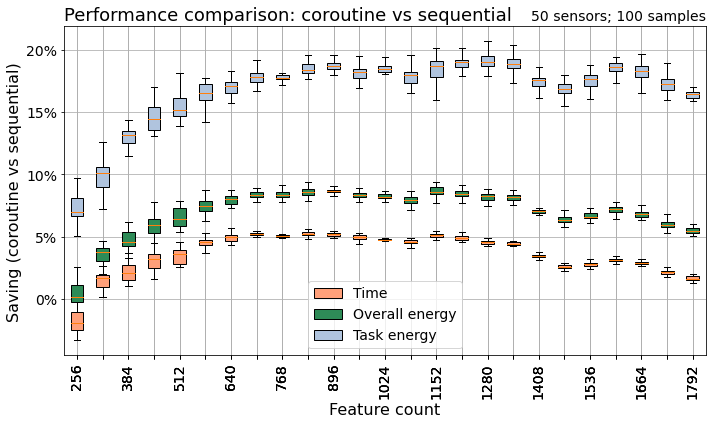

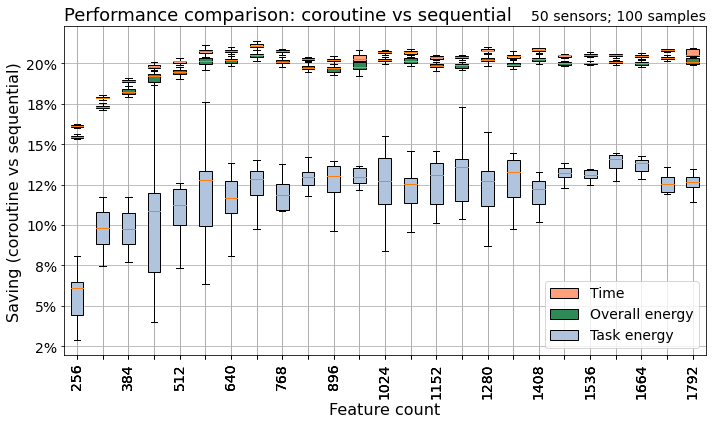

In [7]:
# Comment - a good chart.
# Uses spike_data

def good_box_w_chart(i_platform, full_size):
    values = ['duration', 'spike_power', 'adjusted_power']
    titles = ['Time', 'Overall energy', 'Task energy']
    colors = ['lightsalmon', 'seagreen', 'lightsteelblue']

    if full_size:
        font_size_suptitle = 18
        font_size_title = 14
        font_size_xlabel = 16
        font_size_ylabel = 16
        font_size_legend = 14
    else:
        font_size_suptitle = 30
        font_size_title = 18
        font_size_xlabel = 18
        font_size_ylabel = 18
        font_size_legend = 18

    ds = spike_data[i_platform].query(f'sensors=={nsensors} & samples=={nsamples} & datagram>={min_datagram} & datagram<={max_datagram}')
    x = pd.unique(ds['datagram'])
    xlabels = [str(xp) for xp in x]
    xlabels[1:-1:2] = [''] * int(len(xlabels)/2)

    fig, ax = plt.subplots(figsize=(10, 6)) 
    if full_size:
        ax.set_title(f'Performance comparison: coroutine vs sequential', fontsize=font_size_suptitle, loc='left')
        ax.set_title(f'{nsensors} sensors; {nsamples} samples', fontsize=font_size_title, loc='right')
    for i in [0,1,2]:
        y = [(ds[ds['datagram']==d][f'{values[i]}_delta']) * -100 for d in x]
        ax.boxplot(y, labels=xlabels, sym='', patch_artist=True, boxprops=dict(facecolor=colors[i]))

    ax.set_xlabel('Feature count', fontsize=font_size_xlabel)
    ax.tick_params(axis='x', labelsize=font_size_title, rotation=90)

    ax.set_ylabel(f'Saving (coroutine vs sequential)', fontsize=font_size_ylabel)
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
    ax.tick_params(axis='y', labelsize=font_size_title)

    # Uncomment this line for more minor y ticks (1%)
    # ax.yaxis.set_minor_locator(mtick.MultipleLocator(1))
    ax.grid(visible=True, which='both', axis='both')
    legend_elements = [Patch(facecolor=colors[j], edgecolor='black', label=titles[j]) for j in [0,1,2]]    
    ax.legend(handles=legend_elements, fontsize=font_size_legend)

    fig.tight_layout()
    plt.savefig(f'{get_image_folder(i_platform)}/boxplot_combined_{nsensors}_{nsamples}.pdf')

# Selection
nsensors = 50
nsamples = 100
min_datagram = 256
max_datagram = 1792

full_size = True

good_box_w_chart(0, full_size)
good_box_w_chart(1, full_size)


## Comparison across sizes

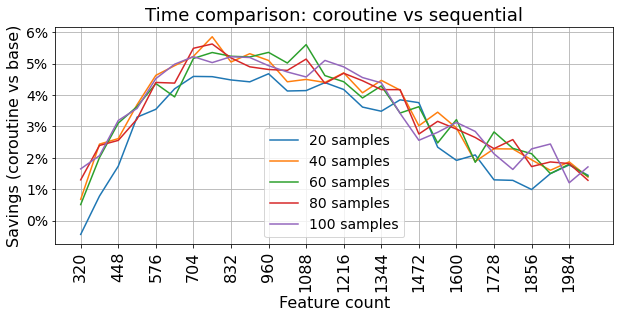

In [8]:
# Based on statsf

dataset = 0
values = ['duration', 'spike_power', 'adjusted_power']
titles = ['Time', 'Total energy', 'Task energy']
i_platform = 0

nsensors = 50
min_datagram = 256

font_size_suptitle = 18
font_size_title = 14
font_size_xlabel = 16
font_size_ylabel = 16
font_size_legend = 14

sf = statsf[i_platform]

statsfex = sf[sf['sensors']==nsensors]
statsfex = statsfex[statsfex['datagram']>min_datagram]
allsamples = statsfex['samples'].unique()
# print(allsamples)

fig, ax = plt.subplots(figsize=(10, 4)) 
for samples in allsamples[1::2]:
    sub = statsfex[statsfex['samples']==samples]
    x = sub['datagram'].values
    y = sub[values[dataset] + '_delta_median'].values * -100
#     print(sub)
    plt.plot(x, y, label = f'{samples} samples')

ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.set_title(f'{titles[dataset]} comparison: coroutine vs sequential', fontsize=font_size_suptitle, loc='center')
# ax.set_title(f'{nsensors} sensors; {nsamples} samples', fontsize=font_size_title, loc='right')
ax.set_xlabel('Feature count', fontsize=font_size_xlabel)    
ax.tick_params(axis='y', labelsize=font_size_title)
ax.set_xticks(x[::2])
ax.set_xticklabels(x[::2], fontsize=font_size_xlabel, rotation=90)
ax.set_ylabel(f'Savings (coroutine vs base)', fontsize=font_size_ylabel) # (coroutine/base)

ax.legend(fontsize=font_size_legend) #, loc='upper right')
ax.grid()
# plt.savefig(f'{get_image_folder(i_platform)}/{titles[dataset]}_for_{nsensors}_sensors.pdf')

# Compare DG response between multiple sensor counts

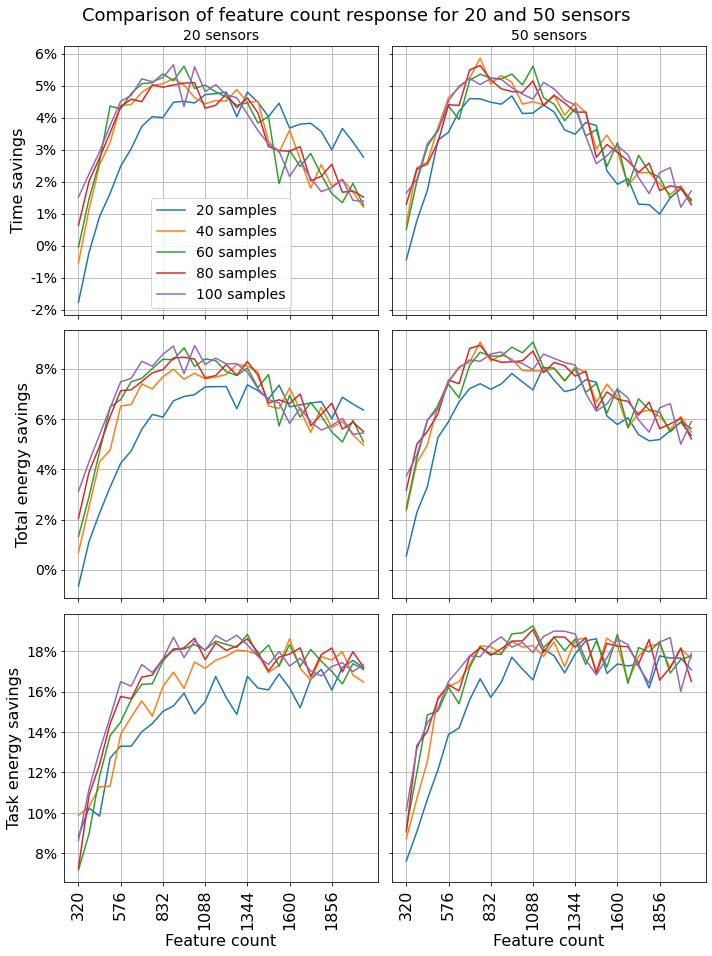

In [9]:
# Not used 

values = ['duration', 'spike_power', 'adjusted_power']
titles = ['Time', 'Total energy', 'Task energy']
i_platform = 0

nsensors = [20, 50]
min_datagram = 256

font_size_suptitle = 18
font_size_title = 14
font_size_xlabel = 16
font_size_ylabel = 16
font_size_legend = 14

# print(allsamples)

fig, axs = plt.subplots(3, 2, figsize=(10, 13.5))
for j in [0, 1]:        
    axs[1, j].sharex(axs[0, j])
    axs[2, j].sharex(axs[0, j])

for i in [0, 1, 2]:        
    axs[i, 0].sharey(axs[i, 1])

for i in range(0, len(values)):
    for j in range(0, len(nsensors)):
        
        ax = axs[i, j]
        sf = statsf[i_platform]
        statsfex = sf[sf['sensors']==nsensors[j]]
        statsfex = statsfex[statsfex['datagram']>min_datagram]
        allsamples = statsfex['samples'].unique()
        for samples in allsamples[1::2]:
            sub = statsfex[statsfex['samples']==samples]
            x = sub['datagram'].values
            y = sub[values[i] + '_delta_median'].values * -100
            ax.plot(x, y, label = f'{samples} samples')

        ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
        if i == 0:
            ax.set_title(f'\n{nsensors[j]} sensors', fontsize=font_size_title)
        if i == 2:
            ax.set_xlabel('Feature count', fontsize=font_size_xlabel)    
            ax.set_xticks(x[::4])
            ax.set_xticklabels(x[::4], fontsize=font_size_xlabel, rotation=90)
        else:
            plt.setp(ax.get_xticklabels(), visible=False)
        if j == 0:
            ax.set_ylabel(f'{titles[i]} savings', fontsize=font_size_ylabel) # (coroutine/base)
            ax.tick_params(axis='y', labelsize=font_size_title)
        else:
            plt.setp(ax.get_yticklabels(), visible=False)

        ax.grid()

fig.tight_layout()
fig.subplots_adjust(top=0.94)
    
axs[0, 0].legend(fontsize=font_size_legend) #, loc='upper right')
_ = plt.suptitle(f'Comparison of feature count response for {nsensors[0]} and {nsensors[1]} sensors', 
                     fontsize = font_size_suptitle)

# plt.savefig(f'{get_image_folder(i_platform)}/comparison_across_samples.pdf')

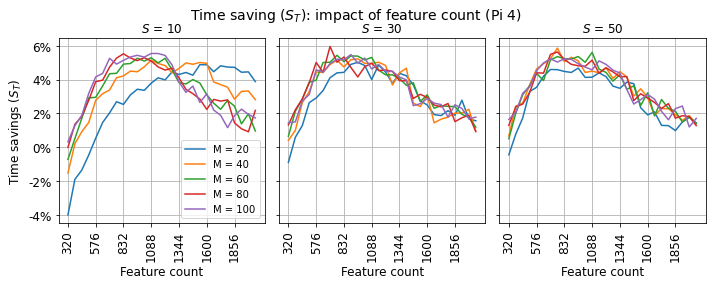

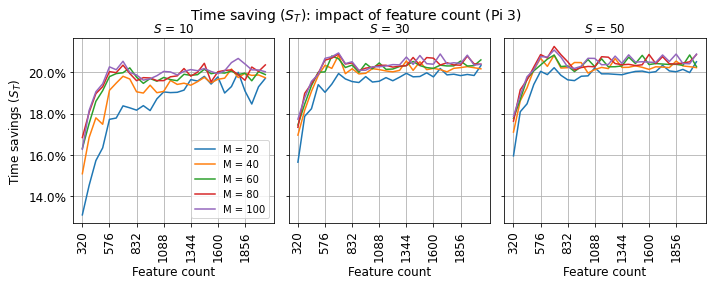

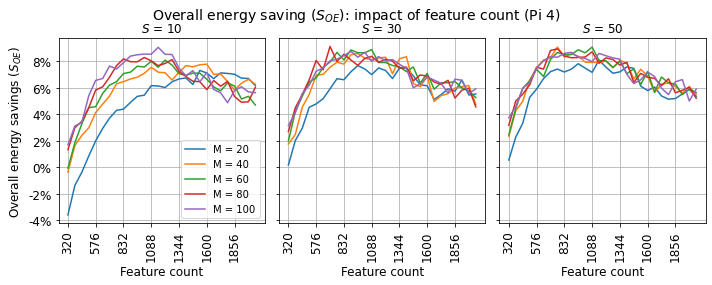

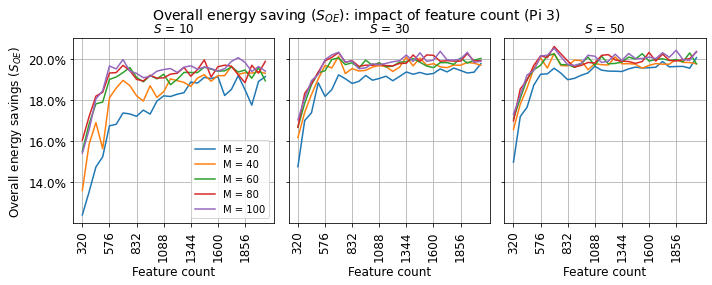

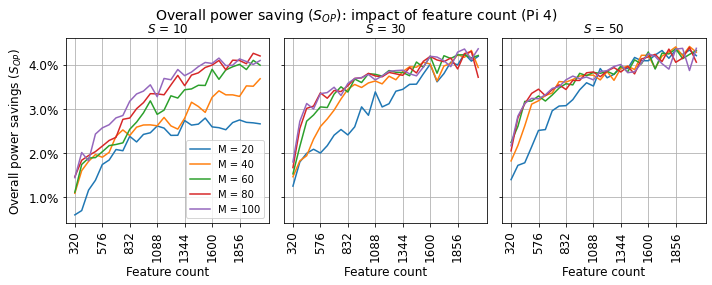

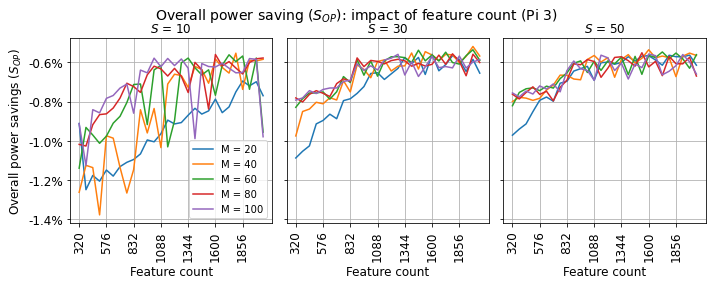

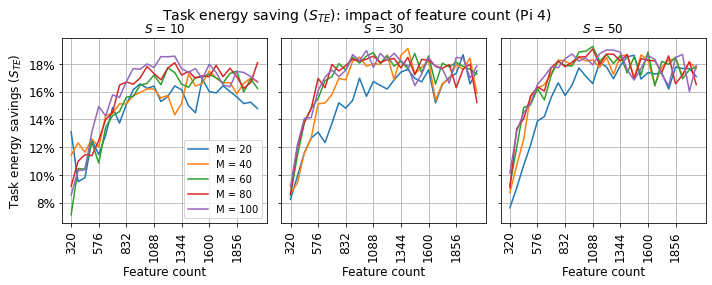

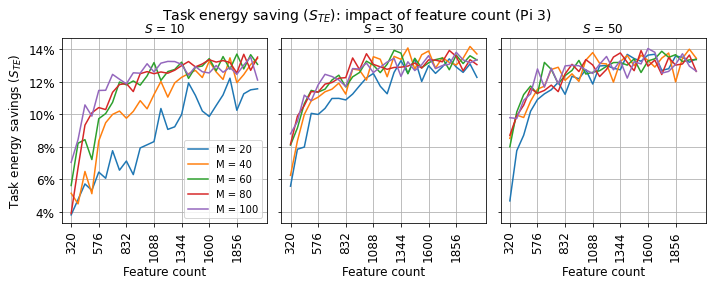

In [10]:
# Shared constants
values = ['duration', 'spike_power', 'spike_median', 'adjusted_power', 'peak_power']
titles = ['Time', 'Overall energy', 'Overall power', 'Task energy', 'Peak power']
symbols = ['$S_{T}$', '$S_{OE}$', '$S_{OP}$', '$S_{TE}$', '$S_{PP}$']
statistics = ['median'] * 5


def compare_dg(i_platform, dataset, nsensors, show_platform=False):
    # Constants
    
    min_datagram = 256

    font_size_suptitle = 14
    font_size_title = 12
    font_size_xlabel = 12
    font_size_ylabel = 12
    font_size_legend = 10
    
    fig, axs = plt.subplots(1, len(nsensors), figsize=(10, 4))

    axs[1].sharey(axs[0])
    axs[2].sharey(axs[0])

    for i in range(0, len(nsensors)):
        ax = axs[i]
        sf = statsf[i_platform]
        statsfex = sf[sf['sensors']==nsensors[i]]
        statsfex = statsfex[statsfex['datagram']>min_datagram]
        allsamples = statsfex['samples'].unique()
        for samples in allsamples[1::2]:
            sub = statsfex[statsfex['samples']==samples]
            x = sub['datagram'].values
            y = sub[f'{values[dataset]}_delta_{statistics[dataset]}'].values * -100
#             ax.plot(x, y, label = f'{samples} samples')
            ax.plot(x, y, label = f'M = {samples}')

#         ax.set_title(f'\n{nsensors[i]} sensors', fontsize=font_size_title)
        ax.set_title(f'\n$S$ = {nsensors[i]}', fontsize=font_size_title)
        dec_places = 0 if (y.max() - y.min()) > 4 else 1
        ax.yaxis.set_major_formatter(mtick.FormatStrFormatter(f'%.{dec_places}f%%'))
        ax.set_xlabel('Feature count', fontsize=font_size_xlabel)    
        ax.set_xticks(x[::4])
        ax.set_xticklabels(x[::4], fontsize=font_size_xlabel, rotation=90)
        if i == 0:
            ax.set_ylabel(f'{titles[dataset]} savings ({symbols[dataset]})', fontsize=font_size_ylabel) # (coroutine/base)
            ax.tick_params(axis='y', labelsize=font_size_title)
        else:
            plt.setp(ax.get_yticklabels(), visible=False)

        ax.grid()

    fig.tight_layout()
    fig.subplots_adjust(top=0.87)
    
    axs[0].legend(fontsize=font_size_legend) #, loc='upper right')
    _ = plt.suptitle(f'{titles[dataset]} saving (' + symbols[dataset] + f'): impact of feature count'
                     + (f' ({short_platform_names[i_platform]})' if show_platform else ''), 
                         fontsize = font_size_suptitle)

    return fig, axs

nsensors = [10, 30, 50]
for ds in [0, 1, 2, 3]:
    for i_platform in platform_indices:
        compare_dg(i_platform, ds, nsensors, True)
        plt.savefig(f'{get_image_folder(i_platform)}/{values[ds]}_comparison_across_samples.pdf')

# compare_dg(3, nsensors)
# plt.savefig(f'{image_folder}/{values[3]}_comparison_across_samples.pdf')


# plt.savefig(f'{image_folder}/comparison_across_samples.pdf')

## Peak power vs Total energy

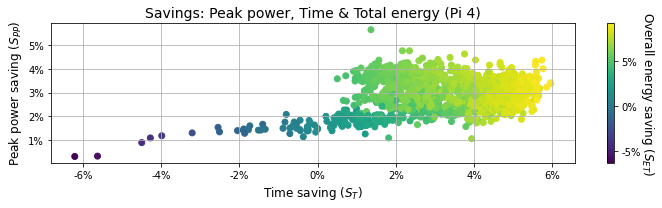

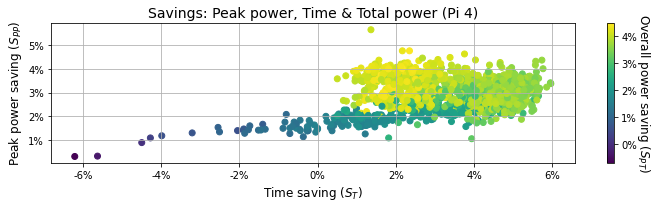

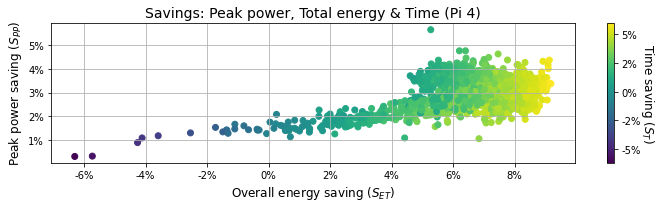

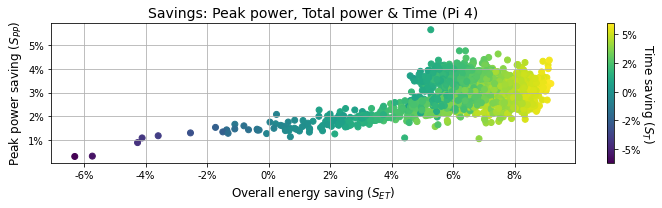

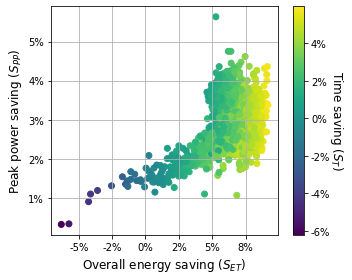

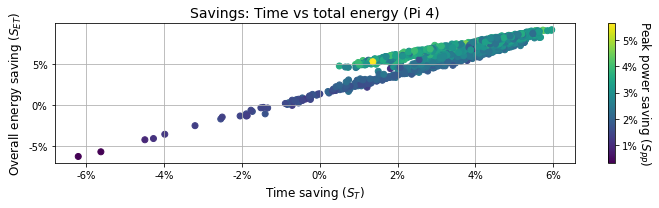

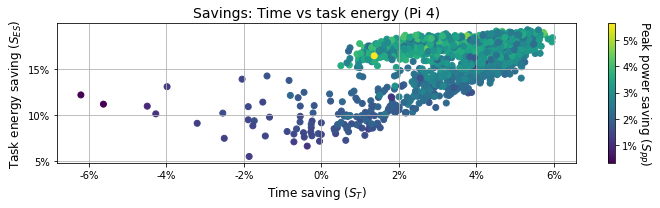

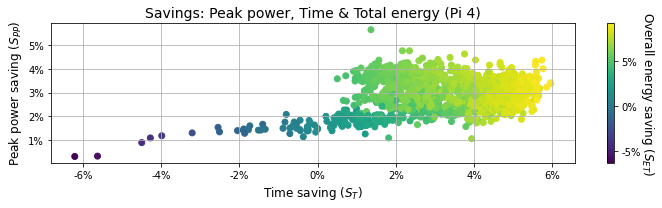

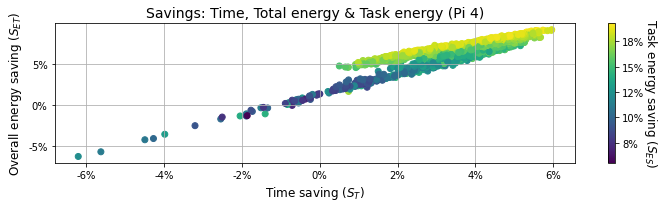

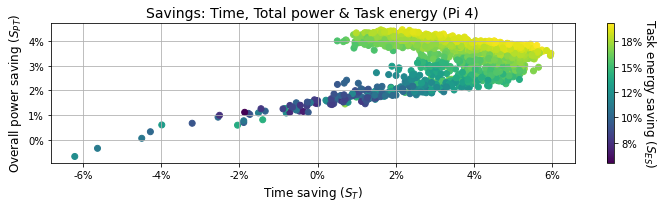

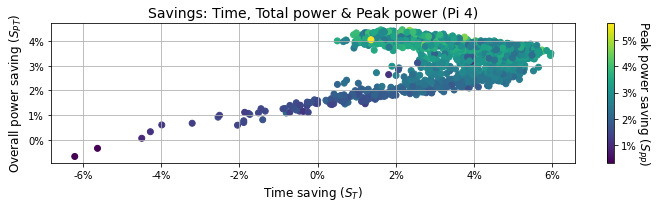

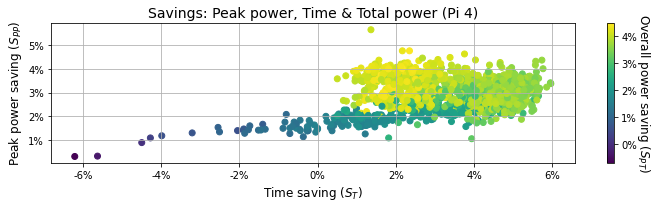

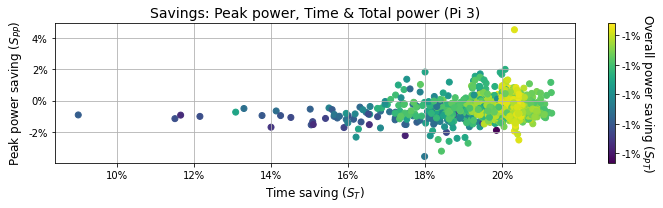

In [77]:
def color_scatter(i_platform, x_data, y_data, c_data, title, wide, i):
    (x_label, x, x_symbol) = x_data
    (y_label, y, y_symbol) = y_data
    (c_label, c, c_symbol) = c_data
    if wide:
        figsize=(10.0, 3.0)
    else:
        figsize=(5.0, 4.0)

    font_size_suptitle = 18
    font_size_title = 14
    font_size_xlabel = 12
    font_size_ylabel = 12
    font_size_legend = 12

    fig, ax = plt.subplots(figsize=figsize)
    im = plt.scatter(x, y, c=c)

    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
    ax.set_ylabel(f'{y_label} saving ({y_symbol})', fontsize=font_size_ylabel)
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
    ax.set_xlabel(f'{x_label} saving ({x_symbol})', fontsize=font_size_ylabel)

    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
    cbar.ax.set_ylabel(f'{c_label} saving ({c_symbol})', rotation=270, fontsize=font_size_ylabel)

    ax.grid()
    if title and wide:
        ax.set_title(f'{title} ({short_platform_names[i_platform]})', fontsize=font_size_title)

    fig.tight_layout()
    plt.savefig(f'{get_image_folder(i_platform)}/savings_scatter_{i}_{"wide" if wide else "narrow"}.pdf')

wide = True
min_datagram = 256
i_platform = 0
sf = statsf[i_platform]
statsfex = sf[sf['datagram']>min_datagram]

time_data = ('Time', statsfex['duration_delta_median'] * -100, '$S_{T}$')
peak_data = ('Peak power', statsfex['peak_power_delta_median'] * -100, '$S_{PP}$')
total_data = ('Overall energy', statsfex['spike_power_delta_median'] * -100, '$S_{ET}$')
task_data = ('Task energy', statsfex['adjusted_power_delta_median'] * -100, '$S_{ES}$')
total_power_data = ('Overall power', statsfex['spike_median_delta_median'] * -100, '$S_{PT}$')

color_scatter(i_platform, time_data, peak_data, total_data, 'Savings: Peak power, Time & Total energy', True, 0)
color_scatter(i_platform, time_data, peak_data, total_power_data, 'Savings: Peak power, Time & Total power', True, 7)
color_scatter(i_platform, total_data, peak_data, time_data, 'Savings: Peak power, Total energy & Time', True, 1)
color_scatter(i_platform, total_data, peak_data, time_data, 'Savings: Peak power, Total power & Time', True, 8)
color_scatter(i_platform, total_data, peak_data, time_data, 'Savings: Peak power, Total energy & Time', False, 2)
color_scatter(i_platform, time_data, total_data, peak_data, 'Savings: Time vs total energy', True, 3)
color_scatter(i_platform, time_data, task_data, peak_data, 'Savings: Time vs task energy', True, 4)
color_scatter(i_platform, time_data, peak_data, total_data, 'Savings: Peak power, Time & Total energy', True, 5)
color_scatter(i_platform, time_data, total_data, task_data, 'Savings: Time, Total energy & Task energy', True, 6)
color_scatter(i_platform, time_data, total_power_data, task_data, 'Savings: Time, Total power & Task energy', True, 13)
color_scatter(i_platform, time_data, total_power_data, peak_data, 'Savings: Time, Total power & Peak power', True, 15)
color_scatter(i_platform, time_data, peak_data, total_power_data, 'Savings: Peak power, Time & Total power', True, 16)


i_platform = 1
sf = statsf[i_platform]
statsfex = sf[sf['datagram']>min_datagram]

time_data = ('Time', statsfex['duration_delta_median'] * -100, '$S_{T}$')
peak_data = ('Peak power', statsfex['peak_power_delta_median'] * -100, '$S_{PP}$')
total_data = ('Overall energy', statsfex['spike_power_delta_median'] * -100, '$S_{ET}$')
task_data = ('Task energy', statsfex['adjusted_power_delta_median'] * -100, '$S_{ES}$')
total_power_data = ('Overall power', statsfex['spike_median_delta_median'] * -100, '$S_{PT}$')

color_scatter(i_platform, time_data, peak_data, total_power_data, 'Savings: Peak power, Time & Total power', True, 17)


# SVM Task Energy

In [12]:
# Select data for Chart

folder = 'data9'
experiment = '4ef67181-ba6b-4693-9d76-d348dd00bb74'
experiment_description = '2 threads; 50 sensors;\n10 snapshots; 1024 FFT bins' 
spike = 4
pattern = 'seq'
truncate = (0.3, 0.65)
use_spike_max = False



Released: 0.13038596800000005 mJ
Returned: 0.18968521199999988 mJ
Total: 4.308169811000009 mJ


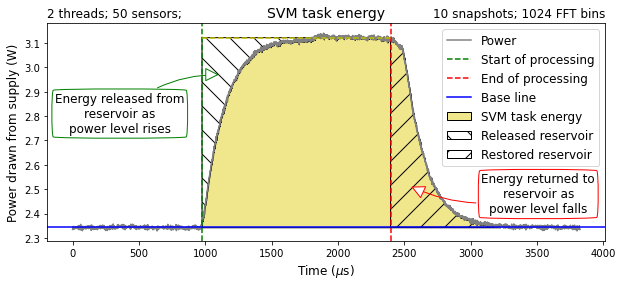

In [13]:
#######################################################
# Load data from CSV file
#
# Note that this data is unrelated to the per-platform 
# datasets used everywhere else in this notebook.
#
# Chart is saved in the image folder for platform 0.
#######################################################

csv_path = f'../python/{folder}/{experiment}_{pattern}_{spike}.csv'
s = pd.read_csv(csv_path)

# Calculate medians of full series
rise_f = np.argwhere(np.diff(s['active']) == 1).flatten()[0]
fall_f = np.argwhere(np.diff(s['active']) == -1).flatten()[0]

# Calculate y values (medians)
opening_median = np.median(s['power'][0:rise_f])
closing_median = np.median(s['power'][fall_f:-1])
base_line_power = (opening_median + closing_median) / 2
spike_median = np.median(s['power'][rise_f:fall_f])
spike_rhs_median = np.median(s['power'][fall_f-int((fall_f-rise_f)/3):fall_f])
spike_max = np.max(s['power'][rise_f:fall_f])
run_power = spike_max if use_spike_max else spike_rhs_median
sample_rate = 1e6

# Truncate ends
row_count = len(s)
s = s.iloc[int(row_count*truncate[0]):int(row_count*truncate[1])].reset_index()

# Calculate x axis indices
rise = np.argwhere(np.diff(s['active']) == 1).flatten()[0]
fall = np.argwhere(np.diff(s['active']) == -1).flatten()[0]

#################################################
# Chart
#################################################
font_size_suptitle = 18
font_size_title = 14
font_size_sub_title = 12
font_size_xlabel = 12
font_size_ylabel = 12
font_size_legend = 12
font_size_notation = 12

fig, ax = plt.subplots(figsize=(10, 4))
t = (s['time'] -s['time'][0])
p = s['power']

plt.title('SVM task energy', fontsize=font_size_title)
[experiment_description_l, experiment_description_r] = experiment_description.split("\n")
plt.title(f'{experiment_description_l}', fontsize=font_size_sub_title, loc='left')
plt.title(f'{experiment_description_r}', fontsize=font_size_sub_title, loc='right')
plt.xlabel(r'Time ($\mu$s)', fontsize=font_size_xlabel)
plt.ylabel('Power drawn from supply (W)', fontsize=font_size_ylabel)

# plt.rcParams["figure.figsize"] = (20, 9) # (w, h)
plt.plot(t, p, label='Power', color='grey')
plt.axvline(x=t[rise], color='g', label='Start of processing', linestyle='dashed')
# plt.plot([t[0], t[rise-1]], [opening_median, opening_median], color='g', label='Opening median')
plt.axvline(x=t[fall], color='r', label='End of processing', linestyle='dashed')
# plt.plot([t[fall+1], t.values[-1]], [closing_median, closing_median], color='r', label='Closing median')
plt.plot([t[rise], t[fall]], [run_power, run_power], color='y', linestyle='dashed')#, label='Running median')
plt.axhline(y=base_line_power, color='b', linestyle='solid', label='Base line')

# Fill in the total power
xei = np.where(p[fall:-1] <= base_line_power)[0][0] + fall
x = t[rise:xei]
y1 = p[rise:xei]
y2 = base_line_power 
plt.fill_between(x, y1, y2, edgecolor='black', facecolor='khaki', label='SVM task energy')#, hatch='/')

# Hatch the "release" segment
x = t[rise:fall]
y1 = p[rise:fall]
y2 = run_power 
plt.fill_between(x, y1, y2, edgecolor='black', facecolor='white', label='Released reservoir', hatch='\\')


rp = y2 - y1
rp[rp<0] = 0
released_power = sum(rp) /sample_rate
print(f'Released: {released_power * 1000} mJ')

# Hatch the "restore" segment
x = t[fall:xei]
y1 = p[fall:xei]
y2 = base_line_power 
plt.fill_between(x, y1, y2, edgecolor='black', facecolor='none', label='Restored reservoir', hatch='/')

rt = y1 - y2
rt[rt<0] = 0
returned_power = sum(rt) /sample_rate
print(f'Returned: {returned_power * 1000} mJ')
p_in_spike = sum(p[rise:fall]) /sample_rate
print(f'Total: {p_in_spike * 1000} mJ')


# Annotate the reservoir segments
resx = t[rise] + ((t[fall]-t[rise]) * 0.1)
resx_offset = resx - t[rise]
resy = p[rise] + ((p[fall]-p[rise]) * 0.8)

ann1 = ax.annotate("Energy released from\nreservoir as\npower level rises", 
                   xy=(resx,resy), xycoords='data', 
                   xytext=(0.13, 0.5), textcoords='axes fraction', size=font_size_notation,
                   bbox=dict(boxstyle="round4", fc="w", color='g'),
                   ha="center",
                   arrowprops=dict(arrowstyle="-|>",mutation_scale=30,connectionstyle="arc3,rad=-0.2",fc="w",color='g'),
                   )

resx = t[fall] + resx_offset
resy = p[rise] + ((p[fall]-p[rise]) * 0.2)

ann1 = ax.annotate("Energy returned to\nreservoir as\npower level falls", 
                   xy=(resx,resy), xycoords='data', 
                   xytext=(0.88, 0.13), textcoords='axes fraction', size=font_size_notation,
                   bbox=dict(boxstyle="round4", fc="w", color='r'),
                   ha="center",
                   arrowprops=dict(arrowstyle="-|>",mutation_scale=30,connectionstyle="arc3,rad=-0.2",fc="w",color='r'),
                   )


plt.legend(fontsize=font_size_legend)
plt.savefig(f'{get_image_folder(0)}/power_usage_pattern.pdf')


# Performance summaries

x:50, y:50, top:50, bottom:50
x:50, y:50, top:50, bottom:50
x:50, y:50, top:50, bottom:50
x:50, y:50, top:50, bottom:50
y [ 20  30  40  50  60  70  80  90 100]
x:45, y:45, top:45, bottom:45
[-0.69498859 -0.61255546 -0.55273106 -0.55369931 -0.5609647  -0.56566179
 -0.55929673 -0.5666061  -0.57811197 -0.59189339 -0.54356205 -0.55517861
 -0.54501341 -0.54502257 -0.5294845  -0.54474795 -0.5507396  -0.54738664
 -0.55844396 -0.53468249 -0.51836564 -0.54661276 -0.53519668 -0.54545291
 -0.55593969 -0.5543315  -0.55857862 -0.53779422 -0.54152406 -0.56597803
 -0.5510592  -0.53099463 -0.54308082 -0.55636765 -0.55298003 -0.56616438
 -0.56264122 -0.53932743 -0.5352544  -0.53526804 -0.5464796  -0.53921167
 -0.55056171 -0.5489119  -0.55706112] [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1.] 8 8
x:50, y:50, top:50, bottom:50


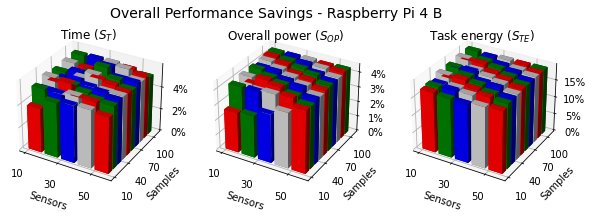

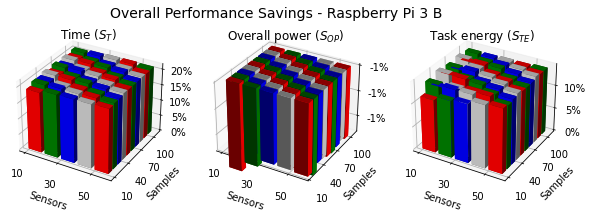

In [79]:
# 3d chart of (sensors * samples) vs best mean improvement 

def draw_3d_row(i_platform):
    targets = ['duration', 'spike_power', 'adjusted_power']
    titles = ['Time ($S_{T}$)', 'Overall energy ($S_{OE}$)', 'Task energy ($S_{TE}$)']
    targets = ['duration', 'spike_median', 'adjusted_power']
    titles = ['Time ($S_{T}$)', 'Overall power ($S_{OP}$)', 'Task energy ($S_{TE}$)']
    colors = ['r', 'g', 'b', 'lightgrey']
    font_size_suptitle = 14
    font_size_title = 12
    font_size_xlabel = 10
    font_size_ylabel = 10
    font_size_zlabel = 10
    font_size_legend = 14

    fig = plt.figure(figsize=(10, 3))
    for i in range(0, len(targets)):
        target = targets[i]
        sf = statsf[i_platform]
        statsf_best = sf.sort_values(f'{target}_delta_median', ascending=True).drop_duplicates(['sensors','samples']) \
            .sort_values(['sensors','samples'], ascending=True)
        if i == 1 & i_platform == 1:
            statsf_best = statsf_best.query(f'samples > 10')

        _x = statsf_best['sensors'].unique()
        _y = statsf_best['samples'].unique()
        _xx, _yy = np.meshgrid(_x, _y)
        x, y = _xx.ravel(), _yy.ravel()
        top = -statsf_best[f'{target}_delta_median'].values * 100
        bottom = np.zeros_like(top)
        width = depth = 8
        color = (colors * ((len(x)//len(colors))+1))[0:len(x)]
        print(f'x:{len(x)}, y:{len(y)}, top:{len(top)}, bottom:{len(bottom)}')
        if i == 1 & i_platform == 1:
            print(top, bottom, width, depth)

        ax1 = fig.add_subplot(1, 3, i + 1, projection='3d')
        ax1.bar3d(x, y, bottom, width, depth, top, shade=True, color = color)
        ax1.set_xlabel('Sensors', fontsize = font_size_xlabel)
        ax1.set_xticks([10, 30, 50])#, labels = ["10", "30", "50"])
        ax1.set_ylabel('Samples', fontsize = font_size_ylabel)
        ax1.set_yticks([10, 40, 70, 100])#, labels = ["10", "30", "50"])
    #     ax1.set_zlabel('Savings', fontsize = font_size_zlabel)
        ax1.zaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
        ax1.set_title(titles[i], fontsize=font_size_title, y=0.97)
    fig.suptitle(f'Overall Performance Savings - {platform_names[i_platform]}', fontsize=font_size_suptitle, y=0.98)
    # fig.tight_layout()
    plt.savefig(f'{get_image_folder(i_platform)}/performance_summary_x_sensors_x_samples.pdf')
    # plt.show()

for i_platform in platform_indices:
    draw_3d_row(i_platform)

# Sample sizes after removal of outliers

In [25]:
# This table should be inserted into the vanet_paper text in table ch6:table:outliers
def print_results_table(i_platform):
    ssi = spike_data[i_platform].groupby(['sensors', 'samples', 'datagram']).size().reset_index(name='counts')
    ticks = list(range(10, 30, 3))
    ticks.reverse()
    print(f'\nData for {platform_names[i_platform]} follows:\n\n')
             
    print(" & ".join(['Count', '\%age']*3)+' \\\\ \hline')
    for l in ticks:
        pop = len(ssi[ssi['counts']>=l][ssi['counts']<=l+2])
        prop = pop / len(ssi)
        print(" & ".join([f'{l}-{l+2}', f'{l/.3:.0f}-{(l+2)/.3:.0f}\%', 
                          f'{28-l}-{30-l}', f'{(28-l)/.3:.0f}-{(30-l)/.3:.0f}\%', 
                          f'{pop}', f'{prop*100:.1f}\%']) + ' \\\\')

for i_platform in platform_indices:
    print_results_table(i_platform)

# Totals
print('\n\n')
for i_platform in platform_indices:
    actual = len(spike_data[i_platform])
    c_sensors = len(spike_data[i_platform]['sensors'].unique())
    c_measurements = len(spike_data[i_platform]['samples'].unique())
    c_features = len(spike_data[i_platform]['datagram'].unique())
    print(f's: {c_sensors}, m: {c_measurements}, f: {c_features}')
    maxrecs = c_sensors * c_measurements * c_features * 30
    perc = actual * 100 / maxrecs
    print(f'{platform_names[i_platform]}: {actual} / {maxrecs} = {perc}%')
    print(f'Loss = {100 - perc:.2f}')
    


Data for Raspberry Pi 4 B follows:


Count & \%age & Count & \%age & Count & \%age \\ \hline
28-30 & 93-100\% & 0-2 & 0-7\% & 956 & 61.7\% \\
25-27 & 83-90\% & 3-5 & 10-17\% & 428 & 27.6\% \\
22-24 & 73-80\% & 6-8 & 20-27\% & 93 & 6.0\% \\
19-21 & 63-70\% & 9-11 & 30-37\% & 45 & 2.9\% \\
16-18 & 53-60\% & 12-14 & 40-47\% & 18 & 1.2\% \\
13-15 & 43-50\% & 15-17 & 50-57\% & 5 & 0.3\% \\
10-12 & 33-40\% & 18-20 & 60-67\% & 5 & 0.3\% \\

Data for Raspberry Pi 3 B follows:


Count & \%age & Count & \%age & Count & \%age \\ \hline
28-30 & 93-100\% & 0-2 & 0-7\% & 446 & 28.8\% \\
25-27 & 83-90\% & 3-5 & 10-17\% & 419 & 27.0\% \\
22-24 & 73-80\% & 6-8 & 20-27\% & 501 & 32.3\% \\
19-21 & 63-70\% & 9-11 & 30-37\% & 158 & 10.2\% \\
16-18 & 53-60\% & 12-14 & 40-47\% & 18 & 1.2\% \\
13-15 & 43-50\% & 15-17 & 50-57\% & 6 & 0.4\% \\
10-12 & 33-40\% & 18-20 & 60-67\% & 2 & 0.1\% \\



s: 5, m: 10, f: 31
Raspberry Pi 4 B: 42436 / 46500 = 91.26021505376345%
Loss = 8.74
s: 5, m: 10, f: 31
Raspberry Pi 3

C:\Users\Bruce\AppData\Local\Temp/ipykernel_6624/2068227153.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pop = len(ssi[ssi['counts']>=l][ssi['counts']<=l+2])


In [20]:
spike_data[0].columns



Index(['experimentid', 'model', 'index', 'start', 'end', 'rise', 'fall',
       'endleak', 'included', 'pairincluded', 'duration', 'opening_median',
       'closing_median', 'spike_median', 'spike_power', 'adjusted_power',
       'peak_power', 'cpu_cycles', 'instructions', 'd_cache_reads',
       'd_cache_misses', 'spike_watts', 'duration_c', 'spike_power_c',
       'adjusted_power_c', 'peak_power_c', 'spike_watts_c', 'spike_median_c',
       'tasks', 'sensors', 'samples', 'datagram', 'duration_delta',
       'spike_power_delta', 'adjusted_power_delta', 'peak_power_delta',
       'spike_watts_delta', 'spike_median_delta'],
      dtype='object')

In [ ]:
# m = ss['peak_power'].mean()
# v = 5.5
# print(m/v * 1000, (m/v)*0.95* 1000, (m/v)*0.98* 1000)

# Results summary table

In [19]:
#
# Prints summary table of all best results for each platform
# To be inserted into section:ch6:full_results
#
summary_stats = [None, None]
for i_platform in [0, 1]:
    dg_min = 704
    statsf2 = statsf[i_platform].query(f'datagram >= {dg_min}')
    # statsf2.groupby(['sensors', 'samples']).agg({'duration_delta_median': ['mean'], 'spike_power_delta_median': ['mean']})
    o = statsf2.groupby(['sensors', 'samples']).agg(ST_max = ('duration_delta_median', 'min'), ST_mean = ('duration_delta_median', 'mean'), ST_sd = ('duration_delta_median', 'std'), 
                                                    SOP_max = ('spike_median_delta_median', 'min'), SOP_mean = ('spike_median_delta_median', 'mean'), SOP_sd = ('spike_median_delta_median', 'std'),
                                                    SOE_max = ('spike_power_delta_median', 'min'), SOE_mean = ('spike_power_delta_median', 'mean'), SOE_sd = ('spike_power_delta_median', 'std'),
                                                    STE_max = ('adjusted_power_delta_median', 'min'), STE_mean = ('adjusted_power_delta_median', 'mean'), STE_sd = ('adjusted_power_delta_median', 'std'),
                                                    SPP_max = ('peak_power_delta_median', 'min'), SPP_mean = ('peak_power_delta_median', 'mean'), SPP_sd = ('peak_power_delta_median', 'std')).reset_index()
    for item in ['ST', 'SOE', 'SOP', 'STE', 'SPP']:
        o[item+'_max'] = o[item+'_max'] * -100
        o[item+'_mean'] = o[item+'_mean'] * -100
        o[item+'_sd'] = o[item+'_sd'] * 100
    # o = o.query(f'sensors != 10 | samples != 10')
    summary_stats[i_platform] = o
#     print(o)

In [20]:
# Data for \label{section:ch6:full_results}

for i_platform in [0, 1]:
    o = summary_stats[i_platform]
    print(f'%% Statistics for {platform_names[i_platform]}')
    print(" & ".join(["Sensors", "Samples", 
                  "\\multicolumn{3}{c|}{Time $S_{T}$}", 
#                   "\\multicolumn{3}{c|}{Overall energy $S_{OE}$}", 
                  "\\multicolumn{3}{c|}{Overall power $S_{OP}$}", 
                  "\\multicolumn{3}{c|}{Task energy $S_{TE}$}",
                  "\\multicolumn{3}{c}{Peak power $S_{PP}$}"]) + "\\\\")
    print(" & ".join(["",""] + ["Max", "Mean", "sd"]*4) + "\\\\ \\hline")
    print("\endhead")
    for index, r in o.iterrows():
        print(f"{r['sensors']:.0f} & {r['samples']:.0f}" 
          + f" & {r['ST_max']:.2f} & {r['ST_mean']:.2f} & {r['ST_sd']:.2f}"
#           + f" & {r['SOE_max']:.2f} & {r['SOE_mean']:.2f} & {r['SOE_sd']:.2f}"
          + f" & {r['SOP_max']:.2f} & {r['SOP_mean']:.2f} & {r['SOP_sd']:.2f}"
          + f" & {r['STE_max']:.2f} & {r['STE_mean']:.2f} & {r['STE_sd']:.2f}"
          + f" & {r['SPP_max']:.2f} & {r['SPP_mean']:.2f} & {r['SPP_sd']:.2f} \\\\")

%% Statistics for Raspberry Pi 4 B
Sensors & Samples & \multicolumn{3}{c|}{Time $S_{T}$} & \multicolumn{3}{c|}{Overall power $S_{OP}$} & \multicolumn{3}{c|}{Task energy $S_{TE}$} & \multicolumn{3}{c}{Peak power $S_{PP}$}\\
 &  & Max & Mean & sd & Max & Mean & sd & Max & Mean & sd & Max & Mean & sd\\ \hline
\endhead
10 & 10 & 3.93 & 2.35 & 1.26 & 2.66 & 2.10 & 0.45 & 17.32 & 14.91 & 1.51 & 2.78 & 2.38 & 0.25 \\
10 & 20 & 4.88 & 3.99 & 0.81 & 2.79 & 2.53 & 0.20 & 16.90 & 15.63 & 0.79 & 2.76 & 2.42 & 0.17 \\
10 & 30 & 5.09 & 4.30 & 0.57 & 3.23 & 2.72 & 0.29 & 16.74 & 15.87 & 0.73 & 3.21 & 2.59 & 0.26 \\
10 & 40 & 5.14 & 4.21 & 0.75 & 3.68 & 2.95 & 0.41 & 17.47 & 16.07 & 0.87 & 3.51 & 2.77 & 0.43 \\
10 & 50 & 4.97 & 3.95 & 0.90 & 4.15 & 3.17 & 0.60 & 17.78 & 16.45 & 0.86 & 4.15 & 3.05 & 0.58 \\
10 & 60 & 5.29 & 3.72 & 1.34 & 4.10 & 3.34 & 0.58 & 17.71 & 16.52 & 0.89 & 3.77 & 3.10 & 0.53 \\
10 & 70 & 5.30 & 3.65 & 1.49 & 4.10 & 3.47 & 0.54 & 18.03 & 16.71 & 0.99 & 4.02 & 3.27 & 0.45 \\
10 &

# Summary
- Fig. performance_summary_across_platforms
- Table ch6:table:summary

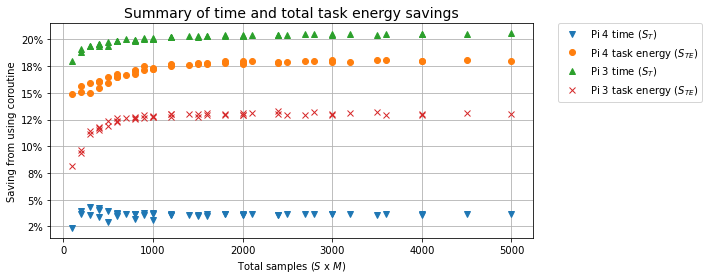

In [101]:
# performance_summary_across_platforms
# Set this to True to get the figures for Table ch6:table:summary
measuring_mode = False

fig, ax = plt.subplots(figsize=(10, 8 if measuring_mode else 4))
te_formats = ['o', 'x']
t_formats= ['v', '^']
font_size_suptitle = 14
font_size_title = 14
font_size_xlabel = 10
font_size_ylabel = 10
font_size_zlabel = 10
font_size_legend = 10

for i_platform in [0, 1]:
    o = summary_stats[i_platform]
    plt.plot(o['sensors']*o['samples'], o['ST_mean'], t_formats[i_platform], 
             label=f'{short_platform_names[i_platform]} time ' + '($S_{T}$)')
    plt.plot(o['sensors']*o['samples'], o['STE_mean'], te_formats[i_platform], 
             label=f'{short_platform_names[i_platform]} task energy ' + '($S_{TE}$)')
# plt.legend(fontsize=font_size_legend, loc='center right')
plt.legend(bbox_to_anchor=(1.05, 1),
                         loc='upper left', borderaxespad=0.)
plt.grid()
ax.set_xlabel('Total samples ($S$ x $M$)', fontsize=font_size_xlabel)
if measuring_mode:
    ax.yaxis.set_minor_locator(mtick.MultipleLocator(.5))
    ax.grid(visible=True, which='both', axis='both')
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f%%'))
else:
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.set_ylabel('Saving from using coroutine', fontsize=font_size_ylabel)
ax.set_title('Summary of time and total task energy savings', fontsize=font_size_title, y=1)
fig.tight_layout()
if ~measuring_mode:
    plt.savefig(f'{get_image_folder(0)}/performance_summary_across_platforms.pdf')
# plt.plot(o['SES_mean'])

#          ST  STE
# Pi 4   3.5% 18.0%
# Pi 3  20.5% 13.0%

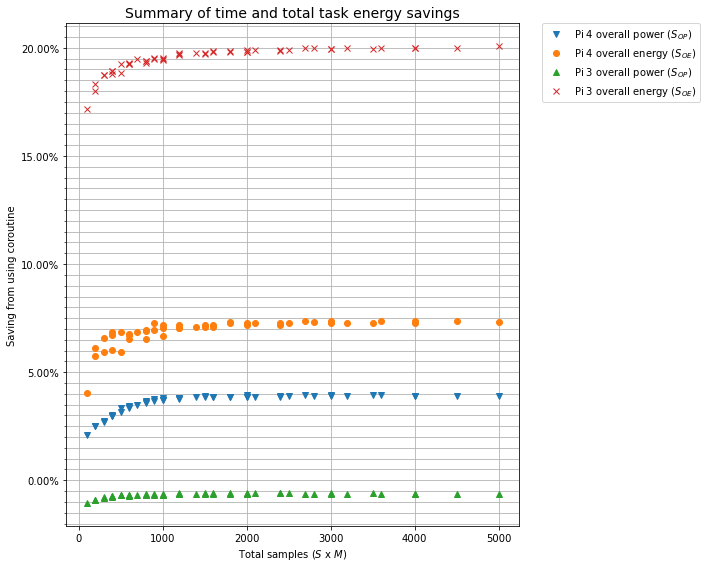

In [102]:
# This chart provides the remaining columns for the summary table ch6:table:summary
# It is not published

fig, ax = plt.subplots(figsize=(10, 8))
te_formats = ['o', 'x']
t_formats= ['v', '^']
font_size_suptitle = 14
font_size_title = 14
font_size_xlabel = 10
font_size_ylabel = 10
font_size_zlabel = 10
font_size_legend = 10

for i_platform in [0, 1]:
    o = summary_stats[i_platform]
    plt.plot(o['sensors']*o['samples'], o['SOP_mean'], t_formats[i_platform], 
             label=f'{short_platform_names[i_platform]} overall power ' + '($S_{OP}$)')
    plt.plot(o['sensors']*o['samples'], o['SOE_mean'], te_formats[i_platform], 
             label=f'{short_platform_names[i_platform]} overall energy ' + '($S_{OE}$)')
# plt.legend(fontsize=font_size_legend, loc='center right')
plt.legend(bbox_to_anchor=(1.05, 1),
                         loc='upper left', borderaxespad=0.)
plt.grid()
ax.set_xlabel('Total samples ($S$ x $M$)', fontsize=font_size_xlabel)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_minor_locator(mtick.MultipleLocator(.5))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f%%'))
ax.grid(visible=True, which='both', axis='both')
ax.set_ylabel('Saving from using coroutine', fontsize=font_size_ylabel)
ax.set_title('Summary of time and total task energy savings', fontsize=font_size_title, y=1)
fig.tight_layout()
plt.savefig(f'{get_image_folder(0)}/performance_summary_across_platforms_soe_sop.pdf')
# plt.plot(o['SES_mean'])

#         SOP   SOE
# Pi 4   4.0%  7.5%
# Pi 3  -0.5% 20.0%

# Compare Pi 4 to Pi  3

0.0034775
0.018051


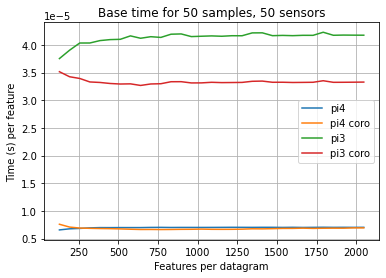

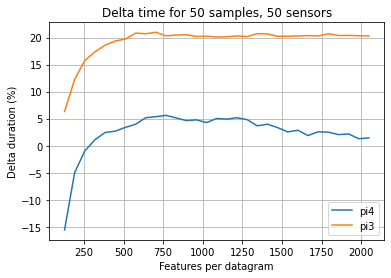

In [61]:
# print(spike_data[0].columns)
# print(spike_data[1].columns)
print(np.median(spike_data[0]['duration']))
print(np.median(spike_data[1]['duration']))


# Statistics
fns = ['mean', 'median', 'std', 'min', 'max', 'count']
stats_base = [None] * len(platforms)
stats_basef = [None] * len(platforms)
for i in platform_indices:
    stats_base[i] = spike_data[i].groupby(['tasks', 'sensors', 'samples', 'datagram']).agg(
        {'duration':fns, 'duration_c':fns, 'duration_delta':fns, 'spike_median':fns, 'spike_median_c':fns})
    stats_basef[i] = stats_base[i].copy(True)
    stats_basef[i].columns = stats_basef[i].columns.map('_'.join)
    stats_basef[i] = stats_basef[i].reset_index()

n_samples = 50
n_sensors = 50
    
for i in platform_indices:
    tmp = stats_basef[i].query(f'sensors=={n_sensors} and samples=={n_samples}')
#     print(tmp)
    plt.plot(tmp['datagram'], tmp['duration_median']/tmp['datagram'], label=platforms[i])
    plt.plot(tmp['datagram'], tmp['duration_c_median']/tmp['datagram'], label=platforms[i] + " coro")

plt.xlabel(f'Features per datagram')
plt.ylabel(f'Time (s) per feature')
plt.title(f'Base time for {n_samples} samples, {n_sensors} sensors')
# plt.yscale("log")
plt.grid()
plt.legend()
plt.show()

for i in platform_indices:
    tmp = stats_basef[i].query(f'sensors=={n_sensors} and samples=={n_samples}')
#     print(tmp)
    plt.plot(tmp['datagram'], tmp['duration_delta_median']*-100, label=platforms[i])

plt.xlabel(f'Features per datagram')
plt.ylabel(f'Delta duration (%)')
plt.title(f'Delta time for {n_samples} samples, {n_sensors} sensors')
plt.grid()
plt.legend()



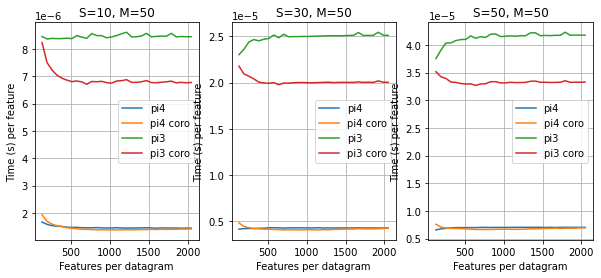

In [62]:
# Extract the best time for each SxMxP
# stats_basef[0]
nsensors = [10, 30, 50]
n_samples = 50
fig, axs = plt.subplots(1, len(nsensors), figsize=(10, 4))
i_platform = 0

for i_platform in [0, 1]:
    for i in range(0, len(nsensors)):
        ax = axs[i]
        tmp = stats_basef[i_platform].query(f'sensors=={nsensors[i]} and samples=={n_samples}')
    #     print(tmp)
        ax.plot(tmp['datagram'], tmp['duration_median']/tmp['datagram'], label=platforms[i_platform])
        ax.plot(tmp['datagram'], tmp['duration_c_median']/tmp['datagram'], label=platforms[i_platform] + " coro")

        ax.set_xlabel(f'Features per datagram')
        ax.set_ylabel(f'Time (s) per feature')
        ax.set_title(f'S={nsensors[i]}, M={n_samples}')
        ax.grid(True)
        ax.legend()


In [63]:
# Statistics - Features per Second (fps) and Features per Watt (fpw)
stats_best = [None] * len(platforms)
stats_bestf = [None] * len(platforms)
fns = ['median']
for i in platform_indices:
    stats_best[i] = spike_data[i].groupby(['tasks', 'sensors', 'samples', 'datagram']).agg(
        {'duration':fns, 'duration_c':fns, 'duration_delta':fns, 
         'spike_power':fns, 'spike_power_c':fns, 'spike_power_delta':fns,
         'adjusted_power':fns, 'adjusted_power_c':fns, 'adjusted_power_delta':fns})
    stats_bestf[i] = stats_best[i].copy(True)
    stats_bestf[i].columns = stats_bestf[i].columns.map('_'.join)
    stats_bestf[i] = stats_bestf[i].reset_index()
    stats_bestf[i]['f'] = stats_bestf[i]['datagram'] * stats_bestf[i]['sensors'] * stats_bestf[i]['samples']
    stats_bestf[i]['fps'] = stats_bestf[i]['f']/stats_bestf[i]['duration_median'] 
    stats_bestf[i]['fps_c'] = stats_bestf[i]['f']/stats_bestf[i]['duration_c_median'] 
    stats_bestf[i]['fpj'] = stats_bestf[i]['f']/stats_bestf[i]['spike_power_median'] 
    stats_bestf[i]['fpj_c'] = stats_bestf[i]['f']/stats_bestf[i]['spike_power_c_median'] 
    stats_bestf[i]['fpja'] = stats_bestf[i]['f']/stats_bestf[i]['adjusted_power_median'] 
    stats_bestf[i]['fpja_c'] = stats_bestf[i]['f']/stats_bestf[i]['adjusted_power_c_median'] 

n_samples = 50
n_sensors = 50
j = 0
stats_bestf[j][stats_bestf[j]['datagram']==1024]

,tasks,sensors,samples,datagram,duration_median,duration_c_median,duration_delta_median,spike_power_median,spike_power_c_median,spike_power_delta_median,adjusted_power_median,adjusted_power_c_median,adjusted_power_delta_median,f,fps,fps_c,fpj,fpj_c,fpja,fpja_c
14,2,10,10,1024,0.000339,0.000335,-0.014749,0.000958,0.000931,-0.030016,0.000285,0.000250,-0.119307,102400,3.020649e+08,3.056716e+08,1.068599e+08,1.099444e+08,3.590497e+08,4.101508e+08
45,2,10,20,1024,0.000622,0.000603,-0.033654,0.001838,0.001745,-0.054343,0.000498,0.000421,-0.162299,204800,3.292605e+08,3.396352e+08,1.114406e+08,1.173567e+08,4.113606e+08,4.867746e+08
76,2,10,30,1024,0.000909,0.000868,-0.044028,0.002731,0.002545,-0.064021,0.000714,0.000596,-0.160285,307200,3.377680e+08,3.539171e+08,1.124676e+08,1.207290e+08,4.299794e+08,5.158479e+08
107,2,10,40,1024,0.001190,0.001133,-0.047519,0.003583,0.003330,-0.070860,0.000927,0.000780,-0.161908,409600,3.443464e+08,3.615181e+08,1.143030e+08,1.230053e+08,4.418779e+08,5.253084e+08
138,2,10,50,1024,0.001478,0.001407,-0.047732,0.004498,0.004172,-0.072106,0.001169,0.000980,-0.158800,512000,3.462969e+08,3.637655e+08,1.138224e+08,1.227352e+08,4.379501e+08,5.224788e+08
169,2,10,60,1024,0.001768,0.001688,-0.050934,0.005363,0.004950,-0.075589,0.001421,0.001174,-0.165897,614400,3.475113e+08,3.639810e+08,1.145609e+08,1.241193e+08,4.322988e+08,5.234521e+08
200,2,10,70,1024,0.002072,0.001952,-0.052961,0.006356,0.005816,-0.079611,0.001643,0.001368,-0.168954,716800,3.459459e+08,3.672131e+08,1.127748e+08,1.232366e+08,4.362448e+08,5.241443e+08
231,2,10,80,1024,0.002357,0.002230,-0.052899,0.007268,0.006671,-0.082770,0.001904,0.001565,-0.178073,819200,3.475605e+08,3.673543e+08,1.127186e+08,1.227986e+08,4.303251e+08,5.234131e+08
262,2,10,90,1024,0.002647,0.002507,-0.049618,0.007920,0.007273,-0.082065,0.002127,0.001753,-0.173931,921600,3.481677e+08,3.676107e+08,1.163574e+08,1.267173e+08,4.331931e+08,5.256454e+08
293,2,10,100,1024,0.002922,0.002765,-0.053243,0.008978,0.008220,-0.085384,0.002377,0.001954,-0.179919,1024000,3.505049e+08,3.702766e+08,1.140545e+08,1.245720e+08,4.308588e+08,5.240782e+08


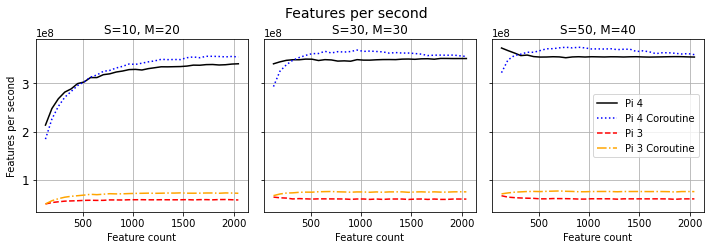

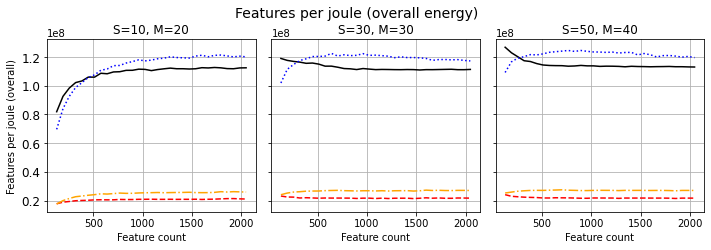

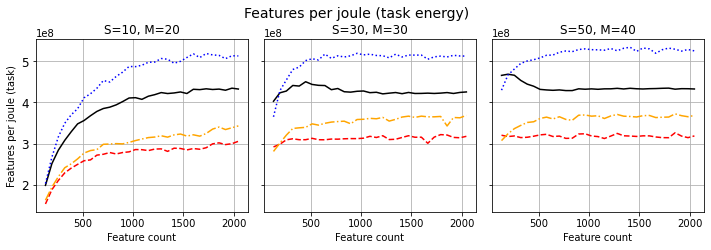

In [64]:
# Investgate stats_bestf[][{'fps', 'fpj'}]
nsensors = [10, 30, 50]
nsamples = [20, 30, 40]
figsize = (10,3.5)
adj_top = 0.85
i_platform = 0

linestyles = ['solid', 'dotted', 'dashed', 'dashdot']
colors = ['black', 'blue', 'red', 'orange']
labels = ['Pi 4', 'Pi 4 Coroutine', 'Pi 3', 'Pi 3 Coroutine']

font_size_suptitle = 14
font_size_title = 12
font_size_ylabel = 10
font_size_xlabel = 10

fig, axs = plt.subplots(1, len(nsensors), figsize=figsize)
fig.suptitle(f'Features per second', fontsize=font_size_suptitle)
axs[1].sharey(axs[0])
axs[2].sharey(axs[0])            

for i_platform in [0, 1]:
    for i in range(0, len(nsensors)):
        ax = axs[i]
        tmp = stats_bestf[i_platform].query(f'sensors=={nsensors[i]} and samples=={nsamples[i]}')
    #     print(tmp)
        ax.plot(tmp['datagram'], tmp['fps'], 
                label=labels[(i_platform*2)], linestyle=linestyles[(i_platform*2)], color=colors[(i_platform*2)])
        ax.plot(tmp['datagram'], tmp['fps_c'], 
                label=labels[(i_platform*2)+1], linestyle=linestyles[(i_platform*2)+1], color=colors[(i_platform*2)+1])

        ax.set_xlabel(f'Feature count')
#         ax.set_ylabel(f'Features per second')
        ax.set_title(f'S={nsensors[i]}, M={nsamples[i]}')
        ax.grid(True)
        if i == 2:
            ax.legend()
        if i == 0:
            ax.set_ylabel(f'Features per second', fontsize=font_size_ylabel)
            ax.tick_params(axis='y', labelsize=font_size_title)
        else:
            plt.setp(ax.get_yticklabels(), visible=False)            
fig.tight_layout()
fig.subplots_adjust(top=adj_top)
plt.savefig(f'{get_image_folder(0)}/fps.pdf')
# plt.show()
    
fig, axs = plt.subplots(1, len(nsensors), figsize=figsize)
fig.suptitle(f'Features per joule (overall energy)', fontsize=font_size_suptitle)
axs[1].sharey(axs[0])
axs[2].sharey(axs[0]) 

for i_platform in [0, 1]:
    for i in range(0, len(nsensors)):
        ax = axs[i]
        tmp = stats_bestf[i_platform].query(f'sensors=={nsensors[i]} and samples=={nsamples[i]}')
    #     print(tmp)
        ax.plot(tmp['datagram'], tmp['fpj'], 
                label=labels[(i_platform*2)], linestyle=linestyles[(i_platform*2)], color=colors[(i_platform*2)])
        ax.plot(tmp['datagram'], tmp['fpj_c'], 
                label=labels[(i_platform*2)+1], linestyle=linestyles[(i_platform*2)+1], color=colors[(i_platform*2)+1])

        ax.set_xlabel(f'Feature count')
#         ax.set_ylabel(f'Features per joule')
        ax.set_title(f'S={nsensors[i]}, M={nsamples[i]}')
        ax.grid(True)
#         if i == 2:
#             ax.legend()
        if i == 0:
            ax.set_ylabel(f'Features per joule (overall)', fontsize=font_size_ylabel)
            ax.tick_params(axis='y', labelsize=font_size_title)
        else:
            plt.setp(ax.get_yticklabels(), visible=False)            
fig.tight_layout()
fig.subplots_adjust(top=adj_top)
plt.savefig(f'{get_image_folder(0)}/fpj.pdf')
# plt.show()

fig, axs = plt.subplots(1, len(nsensors), figsize=figsize)
fig.suptitle(f'Features per joule (task energy)', fontsize=font_size_suptitle)
axs[1].sharey(axs[0])
axs[2].sharey(axs[0])            

for i_platform in [0, 1]:
    for i in range(0, len(nsensors)):
        ax = axs[i]
        tmp = stats_bestf[i_platform].query(f'sensors=={nsensors[i]} and samples=={nsamples[i]}')
    #     print(tmp)
        ax.plot(tmp['datagram'], tmp['fpja'], 
                label=labels[(i_platform*2)], linestyle=linestyles[(i_platform*2)], color=colors[(i_platform*2)])
        ax.plot(tmp['datagram'], tmp['fpja_c'], 
                label=labels[(i_platform*2)+1], linestyle=linestyles[(i_platform*2)+1], color=colors[(i_platform*2)+1])

        ax.set_xlabel(f'Feature count')
#         ax.set_ylabel(f'Features per joule')
        ax.set_title(f'S={nsensors[i]}, M={nsamples[i]}')
        ax.grid(True)
#         if i == 2:
#             ax.legend()
        if i == 0:
            ax.set_ylabel(f'Features per joule (task)', fontsize=font_size_ylabel)
            ax.tick_params(axis='y', labelsize=font_size_title)
#             ax.yaxis.set_major_formatter('{x:.1e}')
        else:
            plt.setp(ax.get_yticklabels(), visible=False)            
fig.tight_layout()
fig.subplots_adjust(top=adj_top)
plt.savefig(f'{get_image_folder(0)}/fpja.pdf')
# plt.show()
        